<center> <h1>1. Deep Neural Networks</h1> </center> 
<center> <h2>by Michelle Veriah</h2> </center> 
<br/>

# Part 1. Data Preprocessing

In [1]:
# import modules 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error

import random
import tqdm

import os 

In [2]:
# Clean up Data 

# Dataset ID for image data 
dataset_id = '20231001-093204_701ae6008a983034ab37e3f3903d1e9f'
prefix = f'https://danylo-ucla.s3-us-west-2.amazonaws.com/app/storage/mnist/jobs/transform_repack/{dataset_id}'

# These three dataframes contain clean images. 
# Use each dataframe to train, validate, and test your model, respectively.
train_clean_X = pd.read_parquet(f'{prefix}/train_clean_x.parquet')
validate_clean_X = pd.read_parquet(f'{prefix}/validate_clean_x.parquet')
test_clean_X = pd.read_parquet(f'{prefix}/test_clean_x.parquet')

# These dataframes are noisy versions of the dataframes above.
train_noisy_X = pd.read_parquet(f'{prefix}/train_noisy_x.parquet')
validate_noisy_X = pd.read_parquet(f'{prefix}/validate_noisy_x.parquet')
test_noisy_X = pd.read_parquet(f'{prefix}/test_noisy_x.parquet')

# This is the segment of the dataset where we do not know the classifications for 
score_noisy_X = pd.read_parquet(f'{prefix}/score_noisy_x.parquet')

# For additional context, these are labels (e.g. digits) corresponding to each image in the dataset. 
# Use it to analyze which digits your models has more or less problems with. 
# These dataframes should not be used as part of the training process itself, only for post-training analysis, if you wish so.
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

In [3]:
print("Data Loaded")

Data Loaded


### Plot Images

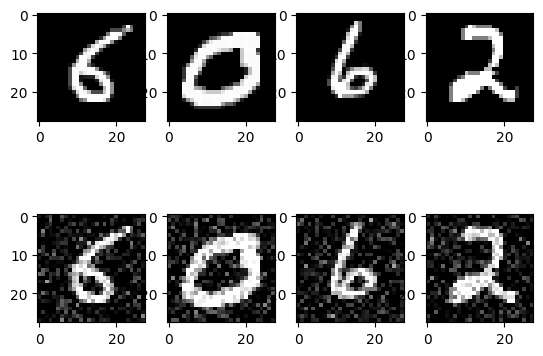

In [4]:
# Plot first four digits of clean data 
plt.subplot(241)
plt.imshow(train_clean_X.loc[0].values.reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.subplot(242)
plt.imshow(train_clean_X.loc[1].values.reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.subplot(243)
plt.imshow(train_clean_X.loc[2].values.reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.subplot(244)
plt.imshow(train_clean_X.loc[3].values.reshape(28, 28), cmap=plt.get_cmap('gray'))

# Plot first four digits of dirty data 
plt.subplot(245)
plt.imshow(train_noisy_X.loc[0].values.reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.subplot(246)
plt.imshow(train_noisy_X.loc[1].values.reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.subplot(247)
plt.imshow(train_noisy_X.loc[2].values.reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.subplot(248)
plt.imshow(train_noisy_X.loc[3].values.reshape(28, 28), cmap=plt.get_cmap('gray'))

# Show data
plt.show()

In [5]:
# check out shape of data 
print(train_noisy_X.shape)
print(train_clean_X.shape)
print(validate_noisy_X.shape)
print(validate_clean_X.shape)
print(test_noisy_X.shape)
print(test_clean_X.shape)

(49000, 784)
(49000, 784)
(7000, 784)
(7000, 784)
(7000, 784)
(7000, 784)


<br/>

<br/>

# Part 2. Train AutoEncoder

## Set Up

In [8]:
import json
import uuid
import os

# This function will be used to save each trained model.
def save_model(model: tf.keras.Model, model_path: str):
    os.makedirs(model_path, exist_ok=True)
    tf.keras.models.save_model(model, f'{model_path}/model.keras')
    with open(f'{model_path}/architecture.json', 'w') as f:
        f.write(json.dumps(json.loads(model.to_json()), indent=True))


# This function can be used to load a previously trained model.
def load_model(model_path: str) -> tf.keras.Model:
    return tf.keras.models.load_model(f'{model_path}/model.keras')

In [9]:
# See MLFlow docs for more API examples.
# https://mlflow.org/docs/latest/python_api/mlflow.html

import mlflow
mlflow.set_experiment('module_01')
mlflow.tensorflow.autolog(log_models=False, log_input_examples=False, log_model_signatures=False, silent=True)

In [10]:
mlflow.get_experiment_by_name('module_01')

<Experiment: artifact_location='file:///app/mlflow/581931868440549010', creation_time=1696808766201, experiment_id='581931868440549010', last_update_time=1696808766201, lifecycle_stage='active', name='assignment_01', tags={}>

In [11]:
# define architecture of model  

def build_model(encoder_width: int, learning_rate_log: float) -> tf.keras.Model:
    mlflow.log_param('encoder_width', encoder_width)
    mlflow.log_param('learning_rate_log', learning_rate_log)
    
    layers = [
        
        # Encoder Layers 
        # Dense(units=encoder_width, activation='gelu', input_shape=(28*28,)),  # OG 
        Dense(units=500, activation="relu", input_shape=(28*28,)), 
        Dense(units=300, activation="relu"), 
        #Dense(units=100, activation="relu"), 
        #Dense(units=49, activation="relu"), 
        Dense(units=encoder_width, activation="relu"), 
        
        # Decoder layers 
        #Dense(units=49, activation="relu"), 
        #Dense(units=100, activation="relu"), 
        Dense(units=300, activation="relu"),
        Dense(units=500, activation="relu"),
        Dense(units=784, activation="sigmoid"), 
        # Dense(units=28*28, activation='sigmoid') # OG 

    ]

    autoencoder = Sequential(layers)

    autoencoder.compile(
        #optimizer='adam', 
        optimizer=optimizers.Adam(
            learning_rate=0.001 #10 ** learning_rate_log
        ), 
        loss='mean_squared_error',
    )
    return autoencoder

In [12]:
# consfigure ml flow 
from collegium.foundation.callbacks import MlflowCallback
import tempfile

# define train model 
def train_anomaly_model(model: tf.keras.Model, epochs: int, verbose: int = 10) -> tf.keras.callbacks.History:
    history = model.fit(
        x=train_noisy_X, #train_noisy_X, 
        y=train_clean_X, #train_clean_X, 

        # It's a good idea to have low number of epochs, to test the learning process, but not for the final model training.
        epochs=epochs,
        batch_size=128, #64
        shuffle=True,
        
        validation_data=(validate_noisy_X, validate_clean_X), #(validate_noisy_X, validate_clean_X),
        callbacks=[MlflowCallback()],
        verbose=verbose
    )
    
    # Save model parameters to the file system and upload to MLFlow.
    with tempfile.TemporaryDirectory('wb') as d:
        model_path = f'{d}/model'
        save_model(model, model_path)
        mlflow.log_artifacts(d)
    
    return history

## Start Training

In [13]:
np.random.seed(11)
tf.random.set_seed(11)

with mlflow.start_run():
    autoencoder = build_model(encoder_width=10, learning_rate_log=-6)
    history = train_anomaly_model(autoencoder, epochs=10)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [14]:
# Predict (using training set for now) 
train_denoised_X = autoencoder.predict(train_noisy_X)
train_denoised_X = pd.DataFrame(train_denoised_X)

Noisy Images


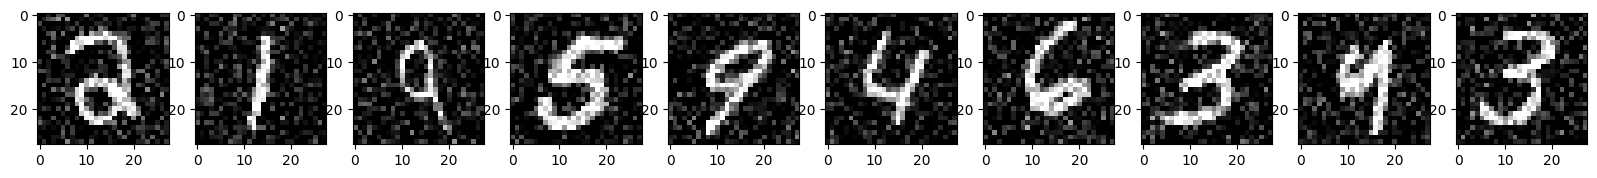

Denoised Images


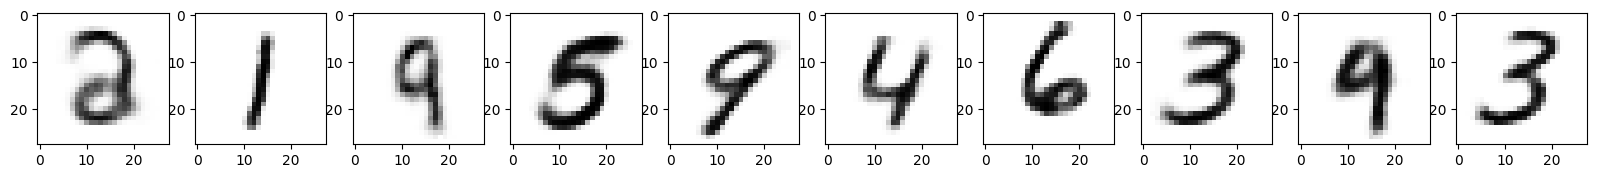

Clean Images


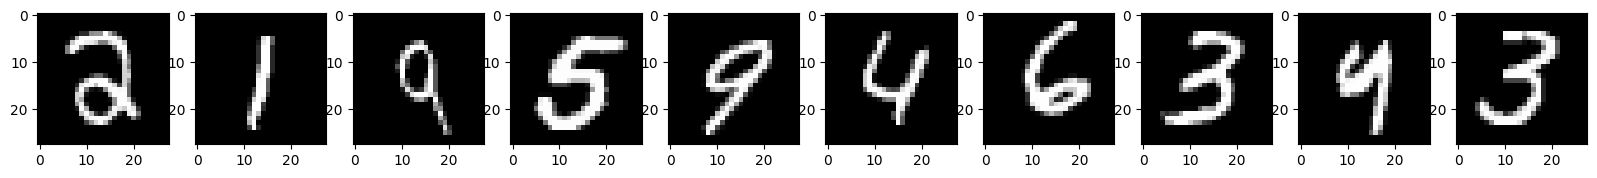

In [15]:
# Print noisy images 
plt.figure(figsize=(20, 4))
print("Noisy Images") 
for i in range (10, 20, 1): 
    plt.subplot(2, 10, i+1)
    plt.imshow(train_noisy_X.loc[i].values.reshape(28, 28), cmap='gray')
plt.show()
    
# Print denoised images 
plt.figure(figsize=(20, 4))
print("Denoised Images") 
for i in range (10, 20, 1): 
    plt.subplot(2, 10, i+1)
    plt.imshow(train_denoised_X.loc[i].values.reshape(28, 28), cmap='binary')
    #plt.imshow(train_denoised_X[i].reshape((28, 28)), cmap='gray')
plt.show()

# Print clean images 
plt.figure(figsize=(20, 4))
print("Clean Images") 
for i in range (10, 20, 1): 
    plt.subplot(2, 10, i+1)
    plt.imshow(train_clean_X.loc[i].values.reshape(28, 28), cmap='gray')
plt.show()

In [16]:
# Calculate MSE on training set 
mean_squared_error(train_denoised_X, train_clean_X)

0.017102187

In [17]:
# Check out validate dataset 
validate_denoised_X = autoencoder.predict(validate_noisy_X)
validate_denoised_X = pd.DataFrame(validate_denoised_X)
mean_squared_error(validate_denoised_X, validate_clean_X)

0.01850112

In [18]:
# Check out test dataset 
test_denoised_X = autoencoder.predict(test_noisy_X)
test_denoised_X = pd.DataFrame(test_denoised_X)
mean_squared_error(test_denoised_X, test_clean_X)

0.018296544

## Hypertune Parameters 

In [20]:
runs = 10
learning_rate_logs = [random.uniform(-5, -2) for _ in range(runs)]
encoder_widths = [random.choice(range(50, 200, 50)) for _ in range(runs)]
#epochs_choice = [random.choice(range(5, 20, 5)) for _ in range(runs)]
parameters = list(zip(learning_rate_logs, encoder_widths))

for (learning_rate_log, encoder_width) in tqdm.tqdm(parameters):
    print("Final encoder width:", encoder_width)
    print("Final learning rate:", 10**learning_rate_log)
    with mlflow.start_run():
        autoencoder = build_model(encoder_width=encoder_width, learning_rate_log=learning_rate_log)
        history = train_anomaly_model(autoencoder, epochs=15, verbose=1)
    # figure out MSE 
    train_denoised_X = autoencoder.predict(train_noisy_X)
    train_denoised_X = pd.DataFrame(train_denoised_X)
    print("Training MSE: ", mean_squared_error(train_denoised_X, train_clean_X)) 
    validate_denoised_X = autoencoder.predict(validate_noisy_X)
    validate_denoised_X = pd.DataFrame(validate_denoised_X)
    print("Validation MSE: ", mean_squared_error(validate_denoised_X, validate_clean_X)) 
    test_denoised_X = autoencoder.predict(test_noisy_X)
    test_denoised_X = pd.DataFrame(test_denoised_X)
    print("Testing MSE: ", mean_squared_error(test_denoised_X, test_clean_X)) 

  0%|          | 0/10 [00:00<?, ?it/s]

Final encoder width: 150
Final learning rate: 0.004324237593290823
Epoch 1/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0363 - val_loss: 0.0178
Epoch 2/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0147 - val_loss: 0.0128
Epoch 3/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0116 - val_loss: 0.0109
Epoch 4/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 5/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0090 - val_loss: 0.0088
Epoch 6/15
383/383 [==============================] - 6s 16ms/step - loss: 0.0083 - val_loss: 0.0084
Epoch 7/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0077 - val_loss: 0.0079
Epoch 8/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0073 - val_loss: 0.0080
Epoch 9/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0070 - val_loss: 0.0073
Epoch 10/15
383/383 [===

 10%|█         | 1/10 [01:34<14:06, 94.09s/it]

Testing MSE:  0.0062303403
Final encoder width: 150
Final learning rate: 0.001659677375227642
Epoch 1/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0372 - val_loss: 0.0187
Epoch 2/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0155 - val_loss: 0.0134
Epoch 3/15
383/383 [==============================] - 6s 16ms/step - loss: 0.0121 - val_loss: 0.0113
Epoch 4/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0104 - val_loss: 0.0099
Epoch 5/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0093 - val_loss: 0.0091
Epoch 6/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 7/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0080 - val_loss: 0.0081
Epoch 8/15
383/383 [==============================] - 6s 16ms/step - loss: 0.0075 - val_loss: 0.0079
Epoch 9/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0072 - val_loss: 0.00

 20%|██        | 2/10 [03:08<12:35, 94.41s/it]

Testing MSE:  0.006418457
Final encoder width: 150
Final learning rate: 4.9909839311122873e-05
Epoch 1/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0366 - val_loss: 0.0185
Epoch 2/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0151 - val_loss: 0.0128
Epoch 3/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0117 - val_loss: 0.0109
Epoch 4/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0101 - val_loss: 0.0099
Epoch 5/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0090 - val_loss: 0.0088
Epoch 6/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 7/15
383/383 [==============================] - 6s 14ms/step - loss: 0.0078 - val_loss: 0.0079
Epoch 8/15
383/383 [==============================] - 5s 13ms/step - loss: 0.0074 - val_loss: 0.0079
Epoch 9/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0070 - val_loss: 0.0

 30%|███       | 3/10 [04:42<10:59, 94.25s/it]

Testing MSE:  0.006298289
Final encoder width: 100
Final learning rate: 0.006076633888831401
Epoch 1/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0377 - val_loss: 0.0191
Epoch 2/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0159 - val_loss: 0.0139
Epoch 3/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0125 - val_loss: 0.0117
Epoch 4/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0107 - val_loss: 0.0108
Epoch 5/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 6/15
383/383 [==============================] - 6s 16ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 7/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0082 - val_loss: 0.0084
Epoch 8/15
383/383 [==============================] - 6s 14ms/step - loss: 0.0078 - val_loss: 0.0080
Epoch 9/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0074 - val_loss: 0.007

 40%|████      | 4/10 [06:15<09:21, 93.67s/it]

Testing MSE:  0.0066970354
Final encoder width: 50
Final learning rate: 0.005230261546616469
Epoch 1/15
383/383 [==============================] - 6s 14ms/step - loss: 0.0388 - val_loss: 0.0206
Epoch 2/15
383/383 [==============================] - 5s 13ms/step - loss: 0.0168 - val_loss: 0.0146
Epoch 3/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 4/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0114 - val_loss: 0.0110
Epoch 5/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0103 - val_loss: 0.0101
Epoch 6/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0095 - val_loss: 0.0096
Epoch 7/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0089 - val_loss: 0.0094
Epoch 8/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0085 - val_loss: 0.0088
Epoch 9/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0081 - val_loss: 0.008

 50%|█████     | 5/10 [07:45<07:42, 92.44s/it]

Testing MSE:  0.0075527793
Final encoder width: 150
Final learning rate: 4.400567512086313e-05
Epoch 1/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0355 - val_loss: 0.0178
Epoch 2/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0144 - val_loss: 0.0124
Epoch 3/15
383/383 [==============================] - 6s 14ms/step - loss: 0.0113 - val_loss: 0.0104
Epoch 4/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0097 - val_loss: 0.0100
Epoch 5/15
383/383 [==============================] - 6s 14ms/step - loss: 0.0087 - val_loss: 0.0085
Epoch 6/15
383/383 [==============================] - 6s 16ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 7/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 8/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0071 - val_loss: 0.0076
Epoch 9/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0067 - val_loss: 0.0

 60%|██████    | 6/10 [09:19<06:11, 92.91s/it]

Testing MSE:  0.006237864
Final encoder width: 100
Final learning rate: 0.00070757045738805
Epoch 1/15
383/383 [==============================] - 6s 16ms/step - loss: 0.0376 - val_loss: 0.0190
Epoch 2/15
383/383 [==============================] - 5s 13ms/step - loss: 0.0157 - val_loss: 0.0137
Epoch 3/15
383/383 [==============================] - 5s 13ms/step - loss: 0.0124 - val_loss: 0.0117
Epoch 4/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0107 - val_loss: 0.0108
Epoch 5/15
383/383 [==============================] - 5s 13ms/step - loss: 0.0097 - val_loss: 0.0096
Epoch 6/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 7/15
383/383 [==============================] - 5s 13ms/step - loss: 0.0083 - val_loss: 0.0085
Epoch 8/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0078 - val_loss: 0.0081
Epoch 9/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0074 - val_loss: 0.0080

 70%|███████   | 7/10 [10:47<04:34, 91.38s/it]

Testing MSE:  0.0066843205
Final encoder width: 100
Final learning rate: 0.0003081824112279879
Epoch 1/15
383/383 [==============================] - 6s 14ms/step - loss: 0.0371 - val_loss: 0.0190
Epoch 2/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0154 - val_loss: 0.0132
Epoch 3/15
383/383 [==============================] - 6s 14ms/step - loss: 0.0120 - val_loss: 0.0112
Epoch 4/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0104 - val_loss: 0.0103
Epoch 5/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0093 - val_loss: 0.0092
Epoch 6/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0086 - val_loss: 0.0086
Epoch 7/15
383/383 [==============================] - 6s 16ms/step - loss: 0.0080 - val_loss: 0.0082
Epoch 8/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0076 - val_loss: 0.0080
Epoch 9/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0072 - val_loss: 0.0

 80%|████████  | 8/10 [12:21<03:03, 91.95s/it]

Testing MSE:  0.006584833
Final encoder width: 100
Final learning rate: 1.037542639720281e-05
Epoch 1/15
383/383 [==============================] - 7s 16ms/step - loss: 0.0365 - val_loss: 0.0186
Epoch 2/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0151 - val_loss: 0.0130
Epoch 3/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0117 - val_loss: 0.0109
Epoch 4/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0101 - val_loss: 0.0099
Epoch 5/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 6/15
383/383 [==============================] - 6s 14ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 7/15
383/383 [==============================] - 6s 14ms/step - loss: 0.0078 - val_loss: 0.0082
Epoch 8/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0074 - val_loss: 0.0078
Epoch 9/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0071 - val_loss: 0.00

 90%|█████████ | 9/10 [13:55<01:32, 92.77s/it]

Testing MSE:  0.006410589
Final encoder width: 50
Final learning rate: 2.725890845866053e-05
Epoch 1/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0391 - val_loss: 0.0205
Epoch 2/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0170 - val_loss: 0.0148
Epoch 3/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0135 - val_loss: 0.0127
Epoch 4/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0118 - val_loss: 0.0115
Epoch 5/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0106 - val_loss: 0.0104
Epoch 6/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0098 - val_loss: 0.0100
Epoch 7/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0092 - val_loss: 0.0095
Epoch 8/15
383/383 [==============================] - 5s 14ms/step - loss: 0.0087 - val_loss: 0.0090
Epoch 9/15
383/383 [==============================] - 6s 15ms/step - loss: 0.0084 - val_loss: 0.009

100%|██████████| 10/10 [15:27<00:00, 92.79s/it]

Testing MSE:  0.0079985075


<br/>

<br/>

# Part 3. Final Model 

In [21]:
# Find lowest MSE run id
lowest_run_id = "133fc3a8b8294d1db83d54078325b7a5" 
saved_model_path = mlflow.tracking.MlflowClient().download_artifacts(lowest_run_id, 'model')
autoencoder = load_model(saved_model_path)

In [22]:
# Look at summary of autoencoder 
autoencoder.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_176 (Dense)           (None, 500)               392500    
                                                                 
 dense_177 (Dense)           (None, 300)               150300    
                                                                 
 dense_178 (Dense)           (None, 100)               30100     
                                                                 
 dense_179 (Dense)           (None, 300)               30300     
                                                                 
 dense_180 (Dense)           (None, 500)               150500    
                                                                 
 dense_181 (Dense)           (None, 784)               392784    
                                                                 
Total params: 1,146,484
Trainable params: 1,146,484
N

In [23]:
# Look at training set data 
train_denoised_X = autoencoder.predict(train_noisy_X)
train_denoised_X = pd.DataFrame(train_denoised_X)
print("Training MSE: ", mean_squared_error(train_denoised_X, train_clean_X)) 

# Look at validation set data: 
validate_denoised_X = autoencoder.predict(validate_noisy_X)
validate_denoised_X = pd.DataFrame(validate_denoised_X)
print("Validation MSE: ", mean_squared_error(validate_denoised_X, validate_clean_X)) 

# Look at test set data: 
test_denoised_X = autoencoder.predict(test_noisy_X)
test_denoised_X = pd.DataFrame(test_denoised_X)
print("Testing MSE: ", mean_squared_error(test_denoised_X, test_clean_X)) 

Training MSE:  0.0051135733
Validation MSE:  0.0064049507
Testing MSE:  0.0063562705


Noisy Test Set Images


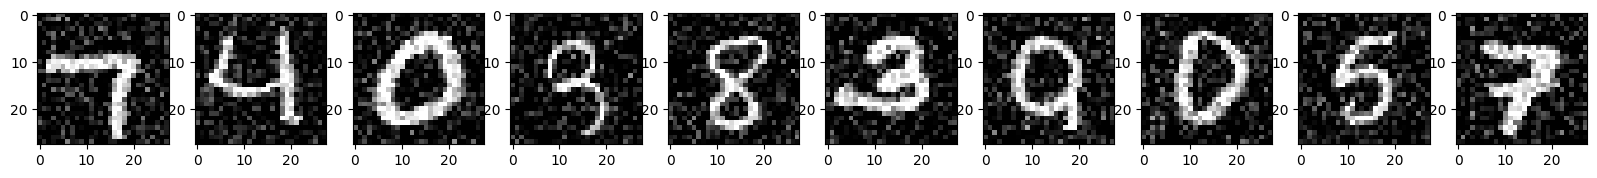

Denoised Test Set Images


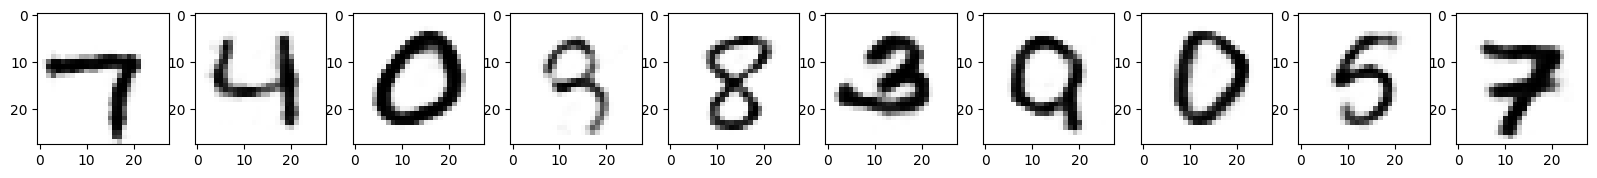

Clean Test Set Images


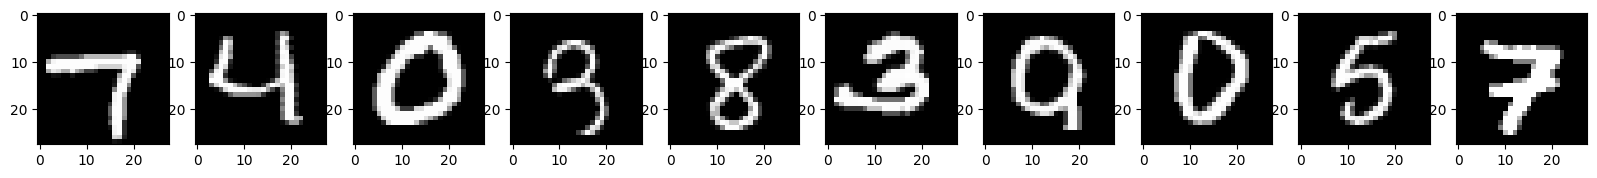

In [24]:
# Look at test set images 

# Print noisy images 
plt.figure(figsize=(20, 4))
print("Noisy Test Set Images") 
for i in range (10, 20, 1): 
    plt.subplot(2, 10, i+1)
    plt.imshow(test_noisy_X.loc[i].values.reshape(28, 28), cmap='gray')
plt.show()
    
# Print denoised images 
plt.figure(figsize=(20, 4))
print("Denoised Test Set Images") 
for i in range (10, 20, 1): 
    plt.subplot(2, 10, i+1)
    plt.imshow(test_denoised_X.loc[i].values.reshape(28, 28), cmap='binary')
    #plt.imshow(train_denoised_X[i].reshape((28, 28)), cmap='gray')
plt.show()

# Print clean images 
plt.figure(figsize=(20, 4))
print("Clean Test Set Images") 
for i in range (10, 20, 1): 
    plt.subplot(2, 10, i+1)
    plt.imshow(test_clean_X.loc[i].values.reshape(28, 28), cmap='gray')
plt.show()

In [25]:
model_path = 'output'

os.makedirs(model_path, exist_ok=True)

# Once you are ready to make the graded submission, run the autoencoder on the score noisy dataset.
score_denoised_X = pd.DataFrame(
    autoencoder.predict(score_noisy_X),
    # This is needed to save the file in Parquet format.
    columns=score_noisy_X.columns
)

# Now save it to disc as a Parquet file.
score_denoised_X.to_parquet(f'{model_path}/score_denoised_x.parquet')

save_model(autoencoder, model_path)

# You now have the following files to be uploaded:
# 1. This notebook and any other Python code you used to train the final model.
# 2. architecture.json -- the model's definition
# 3. model.keras -- the model's trained parameters
# 4. score_denoised_X.parquet - the model's output on the score dataset

Noisy Score_X Images


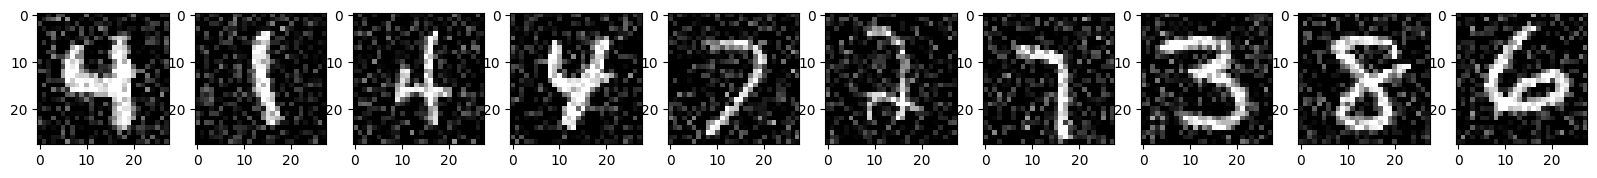

Denoised Score_X Images


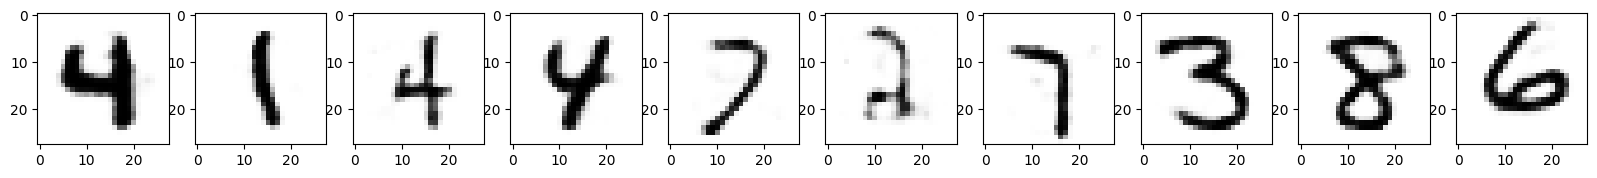

In [26]:
# Print noisy images 
plt.figure(figsize=(20, 4))
print("Noisy Score_X Images") 
for i in range (10, 20, 1): 
    plt.subplot(2, 10, i+1)
    plt.imshow(score_noisy_X.loc[i].values.reshape(28, 28), cmap='gray')
plt.show()
    
# Print denoised images 
plt.figure(figsize=(20, 4))
print("Denoised Score_X Images") 
for i in range (10, 20, 1): 
    plt.subplot(2, 10, i+1)
    plt.imshow(score_denoised_X.loc[i].values.reshape(28, 28), cmap='binary')
plt.show()